In [1]:
import pyodbc
import copy

import pandas as pd
import numpy as np
import re



import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score

### DB Connections

In [2]:
server = 'saab-server-resource.database.windows.net'
database = 'SAAB_DW_Resource'
username = 'saabadmin'
password = 'p@$$w0rd'
cnxn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

### Reading Data

In [3]:
data = pd.read_sql_query("select * from [dbo].[Fact_Audio_Insights] order by [Call_ID],[StartTime];",cnxn)
# Uncomment below if reading manual transcripts from excel file
# data = pd.read_excel("C://Users//mhanagodu//OneDrive - DXC Production//Project//Speech_Analytics_Asset_Building//Files//EnglishManualTranscriptDF.xlsx",sheet_name="Sheet3")

In [4]:
distict_call_ids = list(data['Call_ID'].unique())

### Key Phrases Dictionary Approach

In [5]:
introduction_section = ["how may I help","welcome to","thank you for calling","i am calling from","i can help you","i can assist you with"]
mid_section = ["for verification purpose","I can help you","I will help you","i can assist you with","apologize for","for the inconvenience"]
closure_section = ["thank you for calling","have a pleasant day","have a nice day","i will transfer the call","is there anything else","i can assist you with"]

##### Function to get the Speaker IDs which matches the agent script

In [6]:
def get_speaker_list(sentences_list,keyphrase_list,temp_data):
    indexes_list = []
    speaker_list = []
    for phrase in keyphrase_list:
        indexes_list = [sentences_list.index(x) if phrase in x else '' for x in sentences_list]
        for i in indexes_list:
            if (isinstance(i,int)):
                speaker_list.append(temp_data.loc[i,'SpeakerId'])      
    return speaker_list

##### Identifying speaker ids for different sections

In [11]:
call_id_agent_mapping_dict = {}
for call_id in distict_call_ids:
    
    temp_data = data[data['Call_ID']==call_id][['Call_ID','SpeakerId','StartTime','Display']]
#     print(len(temp_datap_data))
    # Uncomment below if reading manual transcripts from excel file
#     temp_data = data[data['Call_ID']==call_id].reset_index(drop=True)

    # Introduction section check for agent spoken phrases
    intro_speaker_list = get_speaker_list(list(temp_data['Display'][:5]),introduction_section,temp_data)   
    
    # Mid section check for agent spoken phrases
    mid_speaker_list = get_speaker_list(list(temp_data['Display'][5:-5]),mid_section,temp_data)
    
    # Closure section check for agent spoken phrases
    closure_speaker_list = get_speaker_list(list(temp_data['Display'][-5:]),closure_section,temp_data)
    
    # Adding all the most occcuring Speaker IDs from diffent sections into a final list
    final_spk_list = []
    if intro_speaker_list:
        final_spk_list.append(max(intro_speaker_list,key=intro_speaker_list.count))
    if mid_speaker_list:
        final_spk_list.append(max(mid_speaker_list,key=mid_speaker_list.count))
    if closure_speaker_list:
        final_spk_list.append(max(closure_speaker_list,key=closure_speaker_list.count))
    
    # Creating a dictionary containing the SpeakerID flagged as agent
    if final_spk_list:
        call_id_agent_mapping_dict[call_id] = max(final_spk_list,key=final_spk_list.count)
    else:
        call_id_agent_mapping_dict[call_id] = np.nan
#     break
# call_id_agent_mapping_dict

In [ ]:
manual_labelled_df = pd.DataFrame.from_dict(call_id_agent_mapping_dict, orient='index',columns=['Agent_ID']).reset_index().rename(columns={'index':'Call_ID'})

In [ ]:
manual_labelled_df.head()

In [ ]:
# Number of missed transcripts
manual_labelled_df.head()

### Classification approach - on manual transcripts

In [2]:
manual_trasncript_data = pd.read_excel("C://Users//mhanagodu//OneDrive - DXC Production//Project//Speech_Analytics_Asset_Building//Files//EnglishManualTranscriptDF.xlsx",sheet_name="Sheet3")

In [3]:
# manual_trasncript_data = manual_trasncript_data[['SpeakerId','Display']]
manual_trasncript_data.head()

,Call_ID,SpeakerId,Display
0,1-Agent4-2-INC wav,A,hello sir good morning this is alexa how may ...
1,1-Agent4-2-INC wav,C,hi my name is sky i wanted to take a term insu...
2,1-Agent4-2-INC wav,A,sure madam term insurance is the life insuranc...
3,1-Agent4-2-INC wav,C,Alright and how much is the premium and how m...
4,1-Agent4-2-INC wav,A,that benefit will depend on the type of the po...


##### Quality Check
###### Replacing a lowercase labels to an uppercase label

In [4]:
# Quality check 
manual_trasncript_data['SpeakerId'].value_counts()
# Replacing a lowercase labels to an uppercase label
manual_trasncript_data.loc[manual_trasncript_data[manual_trasncript_data['SpeakerId']=="c"].index[0],'SpeakerId'] = 'C'

###### Preprocessing text

In [5]:
# Preprocessing text
lemmatized_text = []
count = 0
for row in manual_trasncript_data.itertuples():
    # Removing extra spaces, special characters and punctuation marks and lower casing the text
    clean_text = re.sub(r'\s\s+',r' ',re.sub(r'[?|$|.|!|#|%|^|*|:|;|,|+|-|_|=|&]',r'',row[3].lower()))
    # Lemmatizing the text
    lemmatized_text.append(" ".join([str(token.lemma_).replace('-PRON-',str(token)) for token in nlp(str(clean_text))]))    

In [6]:
manual_trasncript_data['Lemmatized_Text'] = lemmatized_text

In [7]:
manual_trasncript_data.head(15)

,Call_ID,SpeakerId,Display,Lemmatized_Text
0,1-Agent4-2-INC wav,A,hello sir good morning this is alexa how may ...,hello sir good morning this be alexa how may i...
1,1-Agent4-2-INC wav,C,hi my name is sky i wanted to take a term insu...,hi my name be sky i want to take a term insura...
2,1-Agent4-2-INC wav,A,sure madam term insurance is the life insuranc...,sure madam term insurance be the life insuranc...
3,1-Agent4-2-INC wav,C,Alright and how much is the premium and how m...,alright and how much be the premium and how mu...
4,1-Agent4-2-INC wav,A,that benefit will depend on the type of the po...,that benefit will depend on the type of the po...
5,1-Agent4-2-INC wav,C,okay and one more thing you told me the best b...,okay and one more thing you tell me the good b...
6,1-Agent4-2-INC wav,A,that will be given from the insurance company ...,that will be give from the insurance company t...
7,1-Agent4-2-INC wav,C,And also can i apply for this online,and also can i apply for this online
8,1-Agent4-2-INC wav,A,yeah you can apply online also,yeah you can apply online also
9,1-Agent4-2-INC wav,C,alright fine thank you so much,alright fine thank you so much


##### Stratified Sampling

In [8]:
# xTrain, xTest, yTrain, yTest = train_test_split(manual_trasncript_data['Lemmatized_Text'], manual_trasncript_data['SpeakerId'], test_size = 0.2, random_state = 0)
X = manual_trasncript_data['Lemmatized_Text']
y = manual_trasncript_data['SpeakerId']
sss = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=32)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [9]:
X_train

238     hi i wanna know how do i check my fund value o...
85      good morning hdfc life my name be alexa how ma...
315                                             yeah sure
422     i be sorry madam can i have your name and poli...
122         sir you could just mention your policy number
                              ...                        
768     yeah my name be john and i want to know about ...
570     good afternoon hdfc life customer care this be...
1002    i be keira and my number be four two four one ...
883     you can get in them online also you can get in...
634     my phone number be eight seven one five six se...
Name: Lemmatized_Text, Length: 809, dtype: object

##### Stratified sampling on Train set

In [10]:
# # Stratified sampling on Train set
# X_tra = pd.DataFrame(X_train.reset_index())['Lemmatized_Text']
# y_tra = pd.DataFrame(y_train.reset_index())['SpeakerId']
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
# sss.get_n_splits(X_tra, y_tra)
# for train_index, test_index in sss.split(X_tra, y_tra):
#     X_train_dev, X_test_val = X_tra[train_index], X_tra[test_index]
#     y_train_dev, y_test_val = y_tra[train_index], y_tra[test_index]

In [11]:
# Feature Selection
# Create dummies for classes
y_train_dummies = pd.get_dummies(y_train)

In [12]:
# Convert to token counts
count_vec = CountVectorizer(ngram_range=(2,3),binary=True)
# count_vec = CountVectorizer(binary=True)
X_train_count = count_vec.fit_transform(X_train)
transformer = TfidfTransformer()
X_train_transformed = transformer.fit_transform(X_train_count)

In [13]:
X_train_transformed

<809x11849 sparse matrix of type '<class 'numpy.float64'>'
	with 23323 stored elements in Compressed Sparse Row format>

In [14]:
# print(list(y_train_dummies.columns))
# chi2(X_train_count, y_train_dummies['A'])[0]

##### Select best feature using chi2 to exclude  less weightage feature

In [15]:
# Hyperparameters
no_of_features = 1000
chi_square_threshold = 1

In [16]:
# Select best feature using chi2 to exclude  less weightage feature

columns = list(y_train_dummies.columns)
features_final=[]
chi_probability = []
for col in columns:
    chi_score = chi2(X_train_transformed, y_train_dummies[col])[0]
    chi_prob = chi2(X_train_transformed, y_train_dummies[col])[1]
    features = count_vec.get_feature_names()
    chi_table = pd.DataFrame({'Features':features, 'Chisquare':chi_score , 'Chi_Square_Prob':chi_prob})
    chi_table_cutoff = chi_table.loc[(chi_table["Chisquare"] > chi_square_threshold)] 
    if len(chi_table_cutoff)>no_of_features:
        chi_table = chi_table_cutoff.sort_values(by='Chisquare', ascending=False).head(no_of_features)
    else:
        chi_table = chi_table_cutoff
    features_final.append(chi_table['Features'].tolist())
    chi_probability.append(chi_table['Chisquare'].tolist())
features_all = [item for sublist in features_final for item in sublist]
chi_values_all = [item for sublist in chi_probability for item in sublist]
features_all_table = pd.DataFrame({'Features':features_all , 'Chisquare':chi_values_all})
features_best_chi = pd.DataFrame(features_all_table.groupby(['Features'], as_index=False, sort=False)['Chisquare'].max())
features_best_chi

,Features,Chisquare
0,afternoon hdfc,3.448622
1,afternoon hdfc life,3.448622
2,afternoon welcome,2.684671
3,afternoon welcome to,2.684671
4,alex how,3.753863
...,...,...
320,your full name,2.630036
321,your name,4.468248
322,your name and,3.904318
323,your policy,2.331867


In [17]:
# Finding best k features 
k_val = features_best_chi.shape[0]
scores_f1 = []
for k in range(1, int(k_val), 1):
    features_table = features_best_chi.sort_values('Chisquare', ascending=False).head(k)
    # Bi gram
    model = Pipeline([('vect', CountVectorizer(vocabulary=features_table.Features,ngram_range=(2,3))),
                     ('tfidf', TfidfTransformer()),
                     ('clf',  CalibratedClassifierCV(LinearSVC(penalty="l2", dual=False, tol=1e-3),cv=KFold(n_splits=3))),])#LinearSVC(penalty="l2", dual=False,tol=1e-3)
    # Training the Model
    model.fit(X_train, y_train)
    # Scoring the Model
    predicted = model.predict(X_test)
    scores_f1.append(f1_score(y_test, predicted, average='weighted'))

kvals_list = list(range(1,int(k_val),1))

scores_f1_table = pd.DataFrame({'K_values':kvals_list, 'F1-Score':scores_f1})
kval_top = scores_f1_table.sort_values(by='F1-Score', ascending=False).head(n=10)
kval_optimum = int(kval_top.iloc[0,0])
kval_optimum

283

In [18]:
scores_f1_table

,K_values,F1-Score
0,1,0.546227
1,2,0.546227
2,3,0.546227
3,4,0.553694
4,5,0.553694
...,...,...
319,320,0.866801
320,321,0.866801
321,322,0.866801
322,323,0.866801


In [19]:
import matplotlib.pyplot as plt
plt.plot(scores_f1_table['K_values'], scores_f1_table['F1-Score'])
plt.show()

<Figure size 640x480 with 1 Axes>

##### Training data with optimal features

In [20]:
len(features_best_chi.Features)

325

In [21]:
# Training data with optimal features
features_table_chi_top = features_best_chi.sort_values('Chisquare', ascending=False).head(kval_optimum)

#Using calibrated classifier 
model = Pipeline([('vect', CountVectorizer(vocabulary=features_table_chi_top.Features,ngram_range=(2,3))),
                     ('tfidf', TfidfTransformer()),
                     ('clf',  CalibratedClassifierCV(LinearSVC(penalty="l2", dual=False,tol=1e-3),cv=KFold(n_splits=3)))])

# Training the Model
trained_model=model.fit(X_train, y_train)

In [22]:
trained_model.predict(X_test)

array(['C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'C',
       'C', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'A', 'C', 'A',
       'C', 'C', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'A', 'A', 'A', 'C',
       'A', 'C', 'A', 'A', 'A', 'C', 'C', 'A', 'A', 'A', 'C', 'A', 'C',
       'A', 'A', 'C', 'C', 'A', 'A', 'C', 'C', 'C', 'C', 'A', 'C', 'A',
       'C', 'A', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C',
       'C', 'C', 'A', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'A',
       'C', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'A', 'C',
       'A', 'C', 'C', 'A', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'A', 'A',
       'A', 'C', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C',
       'C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'C', 'C',
       'A', 'A', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'C', 'C', 'C', 'A',
       'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'C', 'C', 'C',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'C

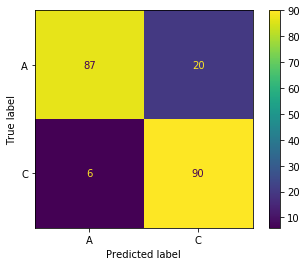

In [23]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(trained_model,X_test,y_test)

In [24]:
trained_model.predict(X_test)

array(['C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'C',
       'C', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'A', 'C', 'A',
       'C', 'C', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'A', 'A', 'A', 'C',
       'A', 'C', 'A', 'A', 'A', 'C', 'C', 'A', 'A', 'A', 'C', 'A', 'C',
       'A', 'A', 'C', 'C', 'A', 'A', 'C', 'C', 'C', 'C', 'A', 'C', 'A',
       'C', 'A', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C',
       'C', 'C', 'A', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'A',
       'C', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'A', 'C',
       'A', 'C', 'C', 'A', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'A', 'A',
       'A', 'C', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C',
       'C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'C', 'C',
       'A', 'A', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'C', 'C', 'C', 'A',
       'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'C', 'C', 'C',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'C

In [25]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
precision_recall_fscore_support(y_test, trained_model.predict(X_test))

(array([0.93548387, 0.81818182]),
 array([0.81308411, 0.9375    ]),
 array([0.87      , 0.87378641]),
 array([107,  96], dtype=int64))

In [26]:
accuracy_score(y_test,trained_model.predict(X_test))

0.8719211822660099

#### Testing on Azure transcripts

##### DB Connections

In [27]:
server = 'saab-server-resource.database.windows.net'
database = 'SAAB_DW_Resource'
username = 'saabadmin'
password = 'p@$$w0rd'
cnxn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

In [28]:
azure_data = pd.read_sql_query("select * from [dbo].[Fact_Audio_Insights] order by [Call_ID],[StartTime];",cnxn)

In [29]:
azure_data.head()

,Call_ID,SpeakerId,StartTime,EndTime,Duration,Lexical,Display,Confidence,Sentiment_Positive,Sentiment_Negative,Sentiment_Neutral,ChannelNumber,Words
0,56482635,2,1.42,22.15,20.73,welcome to H D F C life my name is kai how may...,Welcome to HDFC life my name is Kai how may I ...,0.904177,0,0.996632,0,None,"[{""Word"":""welcome"",""Offset"":14200000,""Duration..."
1,56482635,2,22.86,23.66,0.80,just a second,Just a second.,0.833354831,0,0.184807,0.815172,None,"[{""Word"":""just"",""Offset"":228600000,""Duration"":..."
2,56482635,1,24.78,30.18,5.40,oh yes so mom you can check the fun value of y...,"Oh yes, so mom, you can check the fun value of...",0.9131634,0,0.17315,0.826819,None,"[{""Word"":""oh"",""Offset"":247800000,""Duration"":38..."
3,56482635,2,30.20,34.88,4.68,of my account i have not registered on line is...,"Of my account, I have not registered on line i...",0.9131634,0,1,0,None,"[{""Word"":""of"",""Offset"":302000000,""Duration"":26..."
4,56482635,1,35.80,41.16,5.36,sure mom you may also register this for the SM...,"Sure, mom, you may also register this for the ...",0.904424,0,0.125876,0.874102,None,"[{""Word"":""sure"",""Offset"":358000000,""Duration"":..."


In [30]:
# Quality check 
print(azure_data['SpeakerId'].value_counts())

1    908
2    780
Name: SpeakerId, dtype: int64


In [31]:
# Preprocessing text
azure_lemmatized_text = []
count = 0
for row in azure_data.itertuples():
    # Removing extra spaces, special characters and punctuation marks and lower casing the text
    clean_text = re.sub(r'\s\s+',r' ',re.sub(r'[?|$|.|!|#|%|^|*|:|;|,|+|-|_|=|&]',r'',row[7].lower()))
    # Lemmatizing the text
    azure_lemmatized_text.append(" ".join([str(token.lemma_).replace('-PRON-',str(token)) for token in nlp(str(clean_text))]))    

In [32]:
azure_data['Lemmatized_Text'] = azure_lemmatized_text

In [33]:
azure_distict_call_ids = list(azure_data['Call_ID'].unique())
len(azure_distict_call_ids)

91

In [128]:
# Function returns the count of agent labels for each of the speaker
def get_speaker_A_count(section_spk_list,pred_labels_list):
    labels = {}
    spk_2_count = 0
    spk_1_count = 0
#     print(list(zip(section_spk_list,pred_labels_list)))
    for i in list(zip(section_spk_list,pred_labels_list)):
#         print(i)
        if ((i[0] == 2) and (i[1] == 'A')):
            spk_2_count += 1
        elif ((i[0]==1 and (i[1]=='A'))):
            spk_1_count += 1
    labels['Spk_2_A_Count'] = spk_2_count
    labels['Spk_1_A_Count'] = spk_1_count
    return labels

# Function returns the count of customer labels for each of the speaker
def get_speaker_C_count(section_spk_list,pred_labels_list):
    labels = {}
    spk_2_count = 0
    spk_1_count = 0
    for i in list(zip(section_spk_list,pred_labels_list)):
#         print(i)
        if ((i[0] == 2) and (i[1] == 'C')):
            spk_2_count += 1
        elif ((i[0]==1 and (i[1]=='C'))):
            spk_1_count += 1
    labels['Spk_2_C_Count'] = spk_2_count
    labels['Spk_1_C_Count'] = spk_1_count
    return labels

In [129]:
'''
# Function that assigns the agent/customer label to the speaker ids by 
  evaluating the intro,closure and mid sections of the transcription
  
    Input :
        agent_count_dict : Dictionary with counts of the speakers classified as Agent
        cust_count_dict : Dictionary with counts of the speakers classified as Customer
    Output :
        Return the final speaker ids associated both Agent and Customer
'''
def assign_speaker_by_section(agent_count_dict,cust_count_dict):
    
    agent_speaker = np.nan
    cust_speaker = np.nan

    if (((agent_count_dict['Spk_1_A_Count']) > (cust_count_dict['Spk_1_C_Count'])) and ((cust_count_dict['Spk_2_C_Count']) > (agent_count_dict['Spk_2_A_Count']))):
        agent_speaker = 1
        cust_speaker = 2
    elif (((agent_count_dict['Spk_1_A_Count']) > (cust_count_dict['Spk_1_C_Count'])) and ((cust_count_dict['Spk_2_C_Count']) == (agent_count_dict['Spk_2_A_Count']))):
        agent_speaker = 1
        cust_speaker = 2
    elif (((agent_count_dict['Spk_1_A_Count']) > (cust_count_dict['Spk_1_C_Count'])) and ((cust_count_dict['Spk_2_C_Count']) < (agent_count_dict['Spk_2_A_Count']))):
        if (agent_count_dict['Spk_2_A_Count'] > agent_count_dict['Spk_1_A_Count']):
            agent_speaker = 2
            cust_speaker = 1
        elif ((agent_count_dict['Spk_2_A_Count'] < agent_count_dict['Spk_1_A_Count'])):
            agent_speaker = 1
            cust_speaker = 2
    elif (((agent_count_dict['Spk_1_A_Count']) == (cust_count_dict['Spk_1_C_Count'])) and ((cust_count_dict['Spk_2_C_Count']) > (agent_count_dict['Spk_2_A_Count']))):
        agent_speaker = 1
        cust_speaker = 2
    elif (((agent_count_dict['Spk_1_A_Count']) == (cust_count_dict['Spk_1_C_Count'])) and ((cust_count_dict['Spk_2_C_Count']) == (agent_count_dict['Spk_2_A_Count']))):
        pass
    elif (((agent_count_dict['Spk_1_A_Count']) == (cust_count_dict['Spk_1_C_Count'])) and ((cust_count_dict['Spk_2_C_Count']) < (agent_count_dict['Spk_2_A_Count']))):
        agent_speaker = 2
        cust_speaker = 1        
    elif ((agent_count_dict['Spk_1_A_Count'] < cust_count_dict['Spk_1_C_Count']) and (cust_count_dict['Spk_2_C_Count'] > agent_count_dict['Spk_2_A_Count'])):
        if (cust_count_dict['Spk_2_C_Count'] > cust_count_dict['Spk_1_C_Count']):
            agent_speaker = 1
            cust_speaker = 2
        elif ((cust_count_dict['Spk_2_C_Count'] < cust_count_dict['Spk_1_C_Count'])):
            agent_speaker = 2
            cust_speaker = 1
    elif (((agent_count_dict['Spk_1_A_Count']) < (cust_count_dict['Spk_1_C_Count'])) and ((cust_count_dict['Spk_2_C_Count']) == (agent_count_dict['Spk_2_A_Count']))):
        agent_speaker = 2
        cust_speaker = 1
    elif (((agent_count_dict['Spk_1_A_Count']) < (cust_count_dict['Spk_1_C_Count'])) and ((cust_count_dict['Spk_2_C_Count']) < (agent_count_dict['Spk_2_A_Count']))):
        agent_speaker = 2
        cust_speaker = 1
    return agent_speaker,cust_speaker

In [130]:
# input parameter to define boundaries for intro,mid and closure section
number_of_turns_considered = 5
call_agent_ids = {}
for call_id in azure_distict_call_ids:
    
    temp_data = azure_data[azure_data['Call_ID']==call_id][['Call_ID','SpeakerId','StartTime','Display','Lemmatized_Text']]
    labels = trained_model.predict(temp_data['Lemmatized_Text'])    
    # Assuming always will have a 9 or greater turns
    if len(temp_data) >= 9:
        agent_spk_id = np.nan
        # Getting the speaker id counts for agent label in all the three sections
        intro_A_counts = get_speaker_A_count(list(temp_data[:number_of_turns_considered].SpeakerId),list(labels[:number_of_turns_considered])) 
        closure_A_counts = get_speaker_A_count(list(temp_data[-(number_of_turns_considered):].SpeakerId),list(labels[-(number_of_turns_considered):])) 
        mid_A_counts = get_speaker_A_count(list(temp_data[number_of_turns_considered:-(number_of_turns_considered)].SpeakerId),list(labels[number_of_turns_considered:-(number_of_turns_considered)])) 
        # Getting the speaker id counts for customer label in all the three sections
        intro_C_counts = get_speaker_C_count(list(temp_data[:number_of_turns_considered].SpeakerId),list(labels[:number_of_turns_considered])) 
        closure_C_counts = get_speaker_C_count(list(temp_data[-(number_of_turns_considered):].SpeakerId),list(labels[-(number_of_turns_considered):])) 
        mid_C_counts = get_speaker_C_count(list(temp_data[number_of_turns_considered:-(number_of_turns_considered)].SpeakerId),list(labels[number_of_turns_considered:-(number_of_turns_considered)])) 

        intro_agent_id , intro_cust_id = assign_speaker_by_section(intro_A_counts,intro_C_counts)
        closure_agent_id , closure_cust_id = assign_speaker_by_section(closure_A_counts,closure_C_counts)
        
        # First check intro and closure section for majority count of the speaker ids and then tie breaker using the mid section
        if (intro_agent_id and closure_agent_id):
            if intro_agent_id == closure_agent_id:
                agent_spk_id = intro_agent_id
            else:
                mid_agent_id , mid_cust_id = assign_speaker_by_section(mid_A_counts,mid_C_counts)
                if (mid_agent_id):
                    agent_spk_id = mid_agent_id
        elif (intro_agent_id):
            agent_spk_id = intro_agent_id
        elif (closure_agent_id):
            agent_spk_id = closure_agent_id
        else:
            mid_agent_id , mid_cust_id = assign_speaker_by_section(mid_A_counts,mid_C_counts)
            if (mid_agent_id):
                agent_spk_id = mid_agent_id
                
    call_agent_ids[call_id] = agent_spk_id
    
print(call_agent_ids)

{56482635: 1, 61876574: 1, 85550179: 1, 98762981: 1, 114965010: nan, 136043333: 2, 162945426: 1, 163481267: 1, 167214413: 1, 233293183: 1, 275895380: 1, 285303038: 1, 288021220: 2, 305897728: 1, 338602558: 1, 371832065: 1, 374358082: 1, 380511819: 2, 389319352: 2, 389409373: 1, 396054342: 2, 398009874: 1, 450918322: nan, 484271384: 1, 485256326: 1, 487681759: nan, 489590137: 1, 524243775: 1, 590463931: 1, 598325124: 1, 600759779: 1, 637228575: 1, 728913141: 1, 737900965: 1, 751300664: 1, 767021466: 1, 785577441: 1, 800562374: nan, 810433745: 1, 826213333: 1, 839716088: 1, 857021859: 2, 883920306: 1, 902262381: 2, 925804252: 1, 933609212: 1, 946151767: 2, 946488069: 1, 953480891: 1, 989332127: 1, 1070792302: 1, 1102149543: 2, 1110578904: 1, 1124044940: nan, 1164948814: 1, 1166013485: 1, 1230756464: 2, 1263370672: 2, 1269242652: 1, 1274672835: 1, 1322284147: 1, 1344343262: 2, 1357347108: nan, 1444129832: 2, 1452472041: 1, 1512604259: 2, 1515918096: 2, 1522016959: 2, 1550189214: 2, 168098

In [134]:
testing_df_2 = copy.deepcopy(azure_data)

In [137]:
testing_df_2['Agent_ID'] = testing_df_2['Call_ID'].map(call_agent_ids)
testing_df_2['Labels'] = np.where(testing_df_2['SpeakerId'] == testing_df_2['Agent_ID'],'A','C')
testing_df_2

,Call_ID,SpeakerId,StartTime,EndTime,Duration,Lexical,Display,Confidence,Sentiment_Positive,Sentiment_Negative,Sentiment_Neutral,ChannelNumber,Words,Lemmatized_Text,Agent_ID,Labels
0,56482635,2,1.42,22.15,20.73,welcome to H D F C life my name is kai how may...,Welcome to HDFC life my name is Kai how may I ...,0.904177,0,0.996632,0,None,"[{""Word"":""welcome"",""Offset"":14200000,""Duration...",welcome to hdfc life my name be kai how may i ...,1.0,C
1,56482635,2,22.86,23.66,0.80,just a second,Just a second.,0.833354831,0,0.184807,0.815172,None,"[{""Word"":""just"",""Offset"":228600000,""Duration"":...",just a second,1.0,C
2,56482635,1,24.78,30.18,5.40,oh yes so mom you can check the fun value of y...,"Oh yes, so mom, you can check the fun value of...",0.9131634,0,0.17315,0.826819,None,"[{""Word"":""oh"",""Offset"":247800000,""Duration"":38...",oh yes so mom you can check the fun value of y...,1.0,A
3,56482635,2,30.20,34.88,4.68,of my account i have not registered on line is...,"Of my account, I have not registered on line i...",0.9131634,0,1,0,None,"[{""Word"":""of"",""Offset"":302000000,""Duration"":26...",of my account i have not register on line be t...,1.0,C
4,56482635,1,35.80,41.16,5.36,sure mom you may also register this for the SM...,"Sure, mom, you may also register this for the ...",0.904424,0,0.125876,0.874102,None,"[{""Word"":""sure"",""Offset"":358000000,""Duration"":...",sure mom you may also register this for the sm...,1.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,2146526476,1,77.26,77.75,0.49,different,Different.,0.9043626,0,0.128011,0.871971,None,"[{""Word"":""different"",""Offset"":772600000,""Durat...",different,1.0,A
1684,2146526476,2,79.14,85.72,6.58,OK oh anymore benefits you have from this othe...,"OK, Oh anymore benefits you have from this oth...",0.877409637,0,0.333462,0.666487,None,"[{""Word"":""OK"",""Offset"":791400000,""Duration"":10...",ok oh anymore benefit you have from this other...,1.0,C
1685,2146526476,1,88.21,89.16,0.95,well,Well.,0.8149048,0,0.122798,0.877177,None,"[{""Word"":""well"",""Offset"":882100000,""Duration"":...",well,1.0,A
1686,2146526476,1,91.77,97.02,5.25,the only thing is mom conditional assignment i...,"The only thing is mom, conditional assignment....",0.9049305,0,0.146169,0.853797,None,"[{""Word"":""the"",""Offset"":917700000,""Duration"":2...",the only thing be mom conditional assignment i...,1.0,A


#### Testing

In [127]:
temp_data = azure_data[azure_data['Call_ID']==450918322][['Call_ID','SpeakerId','StartTime','Display','Lemmatized_Text']]
# temp_data
labels = trained_model.predict(temp_data['Lemmatized_Text'])

# print(temp_data)
number_of_turns_considered = 5
if len(temp_data) > 10:
    agent_spk_id = np.nan
    
    intro_A_counts = get_speaker_A_count(list(temp_data[:5].SpeakerId),list(labels[:5])) 
    closure_A_counts = get_speaker_A_count(list(temp_data[-5:].SpeakerId),list(labels[-5:])) 
    mid_A_counts = get_speaker_A_count(list(temp_data[5:-5].SpeakerId),list(labels[5:-5])) 
    intro_C_counts = get_speaker_C_count(list(temp_data[:5].SpeakerId),list(labels[:5])) 
    closure_C_counts = get_speaker_C_count(list(temp_data[-5:].SpeakerId),list(labels[-5:])) 
    mid_C_counts = get_speaker_C_count(list(temp_data[5:-5].SpeakerId),list(labels[5:-5])) 
    
    intro_agent_id , intro_cust_id = assign_speaker_by_section(intro_A_counts,intro_C_counts)
    closure_agent_id , closure_cust_id = assign_speaker_by_section(closure_A_counts,closure_C_counts)
    
    if (intro_agent_id and closure_agent_id):
        
        if intro_agent_id == closure_agent_id:
#             print("yy")
            agent_spk_id = intro_agent_id
        else:
            
            mid_agent_id , mid_cust_id = assign_speaker_by_section(mid_A_counts,mid_C_counts)
            if (mid_agent_id):
#                 print("condition 2")
#                 print(mid_agent_id)
#                 print(mid_A_counts,mid_C_counts)
                agent_spk_id = mid_agent_id
    elif (intro_agent_id):
        agent_spk_id = intro_agent_id
    elif (closure_agent_id):
        agent_spk_id = closure_agent_id
    else:
#         print('cont')
        mid_agent_id , mid_cust_id = assign_speaker_by_section(mid_A_counts,mid_C_counts)
        if (mid_agent_id):
            agent_spk_id = mid_agent_id
        
    print(intro_agent_id,intro_cust_id)
    print(closure_agent_id,closure_cust_id)
    print(mid_agent_id,mid_cust_id)
                
    print("****")
    print(intro_A_counts)
    print(closure_A_counts)
    print(mid_A_counts)
    print("------")
    print(intro_C_counts)
    print(closure_C_counts)
    print(mid_C_counts)
    print("=======================")
    print(agent_spk_id)

{'Spk_2_A_Count': 0, 'Spk_1_A_Count': 2}
{'Spk_2_C_Count': 2, 'Spk_1_C_Count': 1}
......
{'Spk_2_A_Count': 0, 'Spk_1_A_Count': 1}
{'Spk_2_C_Count': 2, 'Spk_1_C_Count': 2}
......
condition pass
{'Spk_2_A_Count': 0, 'Spk_1_A_Count': 1}
{'Spk_2_C_Count': 3, 'Spk_1_C_Count': 3}
......
condition pass
1 2
nan nan
nan nan
****
{'Spk_2_A_Count': 0, 'Spk_1_A_Count': 2}
{'Spk_2_A_Count': 0, 'Spk_1_A_Count': 1}
{'Spk_2_A_Count': 0, 'Spk_1_A_Count': 1}
------
{'Spk_2_C_Count': 2, 'Spk_1_C_Count': 1}
{'Spk_2_C_Count': 2, 'Spk_1_C_Count': 2}
{'Spk_2_C_Count': 3, 'Spk_1_C_Count': 3}
nan


In [59]:
testing_df = pd.DataFrame(azure_data[azure_data['Call_ID']==56482635])
testing_df['Labels'] = labels
testing_df[['SpeakerId','Labels','Display']]

,SpeakerId,Labels,Display
0,2,A,Welcome to HDFC life my name is Kai how may I ...
1,2,C,Just a second.
2,1,A,"Oh yes, so mom, you can check the fun value of..."
3,2,C,"Of my account, I have not registered on line i..."
4,1,C,"Sure, mom, you may also register this for the ..."
5,2,C,Guys have uh so many registration processes. I...
6,1,A,Mom this is just a one time registration pop p...
7,2,C,And you do not have to do anything post that a...
8,1,A,"Oh, fine, I'll do that, OK, ma'am, so you can ..."
9,2,C,Typing Reg space policy number.


#### Creating a dataframe for analysis - manual transcript

In [174]:
manual_trasncript_data

,Call_ID,SpeakerId,Display,Lemmatized_Text
0,1-Agent4-2-INC wav,A,hello sir good morning this is alexa how may ...,hello sir good morning this be alexa how may i...
1,1-Agent4-2-INC wav,C,hi my name is sky i wanted to take a term insu...,hi my name be sky i want to take a term insura...
2,1-Agent4-2-INC wav,A,sure madam term insurance is the life insuranc...,sure madam term insurance be the life insuranc...
3,1-Agent4-2-INC wav,C,Alright and how much is the premium and how m...,alright and how much be the premium and how mu...
4,1-Agent4-2-INC wav,A,that benefit will depend on the type of the po...,that benefit will depend on the type of the po...
...,...,...,...,...
1007,78-Agent1-9-PH(Enroll) wav,A,it will get activated within say one or two wo...,it will get activate within say one or two wor...
1008,78-Agent1-9-PH(Enroll) wav,C,no i'm not talking about activation Im asking ...,no i be not talk about activation i be ask for...
1009,78-Agent1-9-PH(Enroll) wav,A,yeah thats what so if you are doing it right n...,yeah that s what so if you be do it right now ...
1010,78-Agent1-9-PH(Enroll) wav,C,okay then i will give my document,okay then i will give my document


In [179]:
manual_trasncript_data.loc[20,'Call_ID']

'10-Agent2-5-INC wav'

In [185]:
testing_df = X_test.reset_index()
testing_df["Predicted_Values"] = trained_model.predict(X_test)
testing_df['Actual_Values'] = ""
testing_df['Call_ID'] = ""
testing_df
for row in testing_df.itertuples():
    testing_df.loc[row[0],'Call_ID'] = manual_trasncript_data.loc[row[1],'Call_ID']
    testing_df.loc[row[0],'Actual_Values'] = pd.DataFrame(y_test).loc[row[1],'SpeakerId']
testing_df

,index,Lemmatized_Text,Predicted_Values,Actual_Values,Call_ID
0,897,please do not say anything i be contact with y...,C,C,94-Agent3-4-ULP(ch) wav
1,802,sure your one passport size photograph your aa...,C,A,81-Agent2-1-YS(Enroll) wav
2,384,okay thank you if i have any question i will c...,C,C,60-Agent3-8-PP wav
3,47,then what be you sit there for,C,C,45-Agent3-2-RP wav
4,106,sorry sir it vary between the company but our ...,A,A,25-Agent4-INC_converted wav
...,...,...,...,...,...
198,942,yes specifically know about the unit link plan...,C,C,90-Agent3-8-ULP(i) wav
199,812,yeah so i want to know what be the payment and...,C,C,80-Agent2-1-YS(Enquiry) wav
200,898,good afternoon hdfc life customer care this be...,A,A,93-Agent3-4-ULP(e) wav
201,221,the premium for quarterly be six thousand rupe...,C,A,39-Agent3-2-ULP wav


In [190]:
testing_df['Is_Misclassified'] = np.where(testing_df['Predicted_Values']==testing_df['Actual_Values'],0,1)

In [196]:
(testing_df[testing_df['Is_Misclassified']==1])

,index,Lemmatized_Text,Predicted_Values,Actual_Values,Call_ID,Is_Misclassified
1,802,sure your one passport size photograph your aa...,C,A,81-Agent2-1-YS(Enroll) wav,1
8,162,actually it would be refund in a ten working day,C,A,35-Agent3-INC wav,1
11,6,that will be give from the insurance company t...,C,A,1-Agent4-2-INC wav,1
27,804,definitely also the form okay,C,A,81-Agent2-1-YS(Enroll) wav,1
32,143,it will be as per the service provider,C,A,27-Agent2-3-INC_converted wav,1
35,914,what you say i be i be i have your regular thi...,A,C,92-Agent3-4-ULP(c) wav,1
40,533,and your mobile number sir,C,A,71-Agent1-2-EHI(enroll) wav,1
44,1007,it will get activate within say one or two wor...,C,A,78-Agent1-9-PH(Enroll) wav,1
48,20,fine but this be just too much work i be busy ...,A,C,10-Agent2-5-INC wav,1
65,726,be about two thousand four hundred rupee,C,A,86-Agent2-5-YSP(Enquiry) wav,1


In [193]:
testing_df[testing_df['Is_Misclassified']==1].groupby(['Call_ID']).count()

,index,Lemmatized_Text,Predicted_Values,Actual_Values,Is_Misclassified
Call_ID,,,,,
1-Agent4-2-INC wav,1,1,1,1,1
10-Agent2-5-INC wav,1,1,1,1,1
23-Agent4-INC_converted wav,1,1,1,1,1
27-Agent2-3-INC_converted wav,1,1,1,1,1
28-Agent4-INC_converted wav,1,1,1,1,1
35-Agent3-INC wav,1,1,1,1,1
39-Agent3-2-ULP wav,1,1,1,1,1
40-Agent3-2-RP-c wav,1,1,1,1,1
40-Agent3-INC wav,1,1,1,1,1
